In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import netCDF4

import keras
from keras import layers
from keras import backend as K
from keras.models import Model
from keras.losses import binary_crossentropy
import tensorflow as tf
from keras.utils import plot_model
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
#Load Data and map gray scale 256 to number between zero and 1
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.expand_dims(x_train, axis=-1) / 255.
x_test = np.expand_dims(x_test, axis=-1) / 255.

In [3]:
print(x_train.shape)
print(x_test.shape)
Training_Images = np.squeeze(x_train[:8000, :,:,:])
Test_Images= np.squeeze(x_test[:2000, :,:,:])

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [4]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var))*K.exp(log_var/2)+mean

In [5]:
#latent dim
codings_size = 2

batch_size = 128
img_width = len(Training_Images[0])
img_height = len(Training_Images[0][0])
inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.Model(inputs = [inputs], outputs=[codings_mean, codings_log_var, codings])

In [6]:
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28*28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28,28])(x)
variational_decoder = keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [7]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.Model(inputs=[inputs], outputs=[reconstructions])

In [8]:
def kl_reconstruction_loss(true, pred):
    # Reconstruction loss
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
    # KL divergence loss
    kl_loss = 1 + codings_log_var - K.square(codings_mean) - K.exp(codings_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    #On ruihan's advice, I will weight KL down
    kl_weight = 0.1
    return K.mean(reconstruction_loss + kl_weight*kl_loss)
    #return K.mean(reconstruction_loss + kl_loss)


def kl(true, pred):
    kl_loss = 1 + codings_log_var - K.square(codings_mean) - K.exp(codings_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return kl_loss

def reconstruction(true, pred):
    # Reconstruction loss
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
    return reconstruction_loss

In [9]:
#latent_loss = -0.5*K.sum(1+codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis = -1)
#variational_ae.add_loss(K.mean(latent_loss)/784.)
variational_ae.compile(loss=kl_reconstruction_loss, optimizer ="rmsprop", metrics=[kl, reconstruction])
variational_ae.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
model_1 (Model)              [(None, 2), (None, 2), (N 133254    
_________________________________________________________________
model_2 (Model)              (None, 28, 28)            133834    
Total params: 267,088
Trainable params: 267,088
Non-trainable params: 0
_________________________________________________________________


In [10]:
h = variational_ae.fit(Training_Images, Training_Images, epochs=60, batch_size=batch_size, validation_data=[Test_Images, Test_Images])

Train on 8000 samples, validate on 2000 samples
Epoch 1/60
8000/8000 [==============================] - 1s 167us/step - loss: 232.8350 - kl: 46.4796 - reconstruction: 227.9199 - val_loss: 191.1286 - val_kl: 25.3483 - val_reconstruction: 188.4865
Epoch 2/60
8000/8000 [==============================] - 1s 76us/step - loss: 190.1512 - kl: 26.6124 - reconstruction: 187.4695 - val_loss: 182.2938 - val_kl: 25.2018 - val_reconstruction: 179.6976
Epoch 3/60
8000/8000 [==============================] - 1s 76us/step - loss: 182.3024 - kl: 24.7116 - reconstruction: 179.7578 - val_loss: 177.0551 - val_kl: 21.4451 - val_reconstruction: 174.8398
Epoch 4/60
8000/8000 [==============================] - 1s 82us/step - loss: 178.8621 - kl: 22.7399 - reconstruction: 176.5455 - val_loss: 176.4240 - val_kl: 19.6181 - val_reconstruction: 174.3675
Epoch 5/60
8000/8000 [==============================] - 1s 83us/step - loss: 176.2137 - kl: 21.8979 - reconstruction: 173.9516 - val_loss: 172.9457 - val_kl: 22.67

8000/8000 [==============================] - 1s 79us/step - loss: 150.9001 - kl: 15.8514 - reconstruction: 149.3051 - val_loss: 155.8163 - val_kl: 15.8006 - val_reconstruction: 154.1718
Epoch 43/60
8000/8000 [==============================] - 1s 81us/step - loss: 150.7894 - kl: 15.7237 - reconstruction: 149.2040 - val_loss: 155.5845 - val_kl: 16.5365 - val_reconstruction: 153.8810
Epoch 44/60
8000/8000 [==============================] - 1s 78us/step - loss: 150.4525 - kl: 15.7583 - reconstruction: 148.8311 - val_loss: 153.8268 - val_kl: 15.7945 - val_reconstruction: 152.1919
Epoch 45/60
8000/8000 [==============================] - 1s 77us/step - loss: 150.1810 - kl: 15.6899 - reconstruction: 148.7232 - val_loss: 154.1391 - val_kl: 16.2659 - val_reconstruction: 152.4588
Epoch 46/60
8000/8000 [==============================] - 1s 81us/step - loss: 149.8116 - kl: 15.6224 - reconstruction: 148.1765 - val_loss: 154.2470 - val_kl: 15.8026 - val_reconstruction: 152.6050
Epoch 47/60
8000/8000 

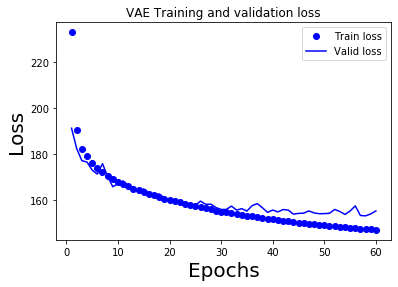

In [11]:
hdict1 = h.history
train_loss_values1 = hdict1['loss']
valid_loss_values1 = hdict1['val_loss']
epochs1 = range(1, len(train_loss_values1) + 1)
plt.plot(epochs1, train_loss_values1, 'bo', label='Train loss')
plt.plot(epochs1, valid_loss_values1, 'b', label='Valid loss')
plt.title('VAE Training and validation loss')
plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
#plt.yscale('log')
plt.legend()
plt.show()
plt.close()

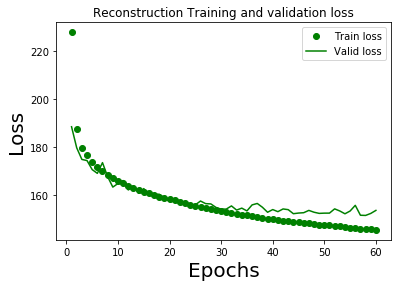

In [12]:
train_loss_values1 = hdict1['reconstruction']
valid_loss_values1 = hdict1['val_reconstruction']
epochs1 = range(1, len(train_loss_values1) + 1)
plt.plot(epochs1, train_loss_values1, 'go', label='Train loss')
plt.plot(epochs1, valid_loss_values1, 'g', label='Valid loss')
plt.title('Reconstruction Training and validation loss')
plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
#plt.yscale('log')
plt.legend()
plt.show()
plt.close()

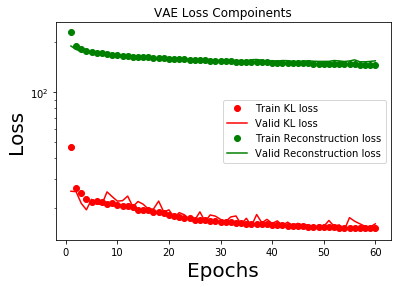

In [13]:
#make a plot for kl and reconstruction loss
kl_train_loss_values1 = hdict1['kl']
kl_valid_loss_values1 = hdict1['val_kl']
recon_train_loss_values1 = hdict1['reconstruction']
recon_valid_loss_values1 = hdict1['val_reconstruction']
epochs1 = range(1, len(train_loss_values1) + 1)
plt.plot(epochs1, kl_train_loss_values1, 'ro', label='Train KL loss')
plt.plot(epochs1, kl_valid_loss_values1, 'r', label='Valid KL loss')
plt.plot(epochs1, recon_train_loss_values1, 'go', label='Train Reconstruction loss')
plt.plot(epochs1, recon_valid_loss_values1, 'g', label='Valid Reconstruction loss')
plt.title('VAE Loss Compoinents')
plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.yscale('log')
plt.legend()
plt.show()
plt.close()

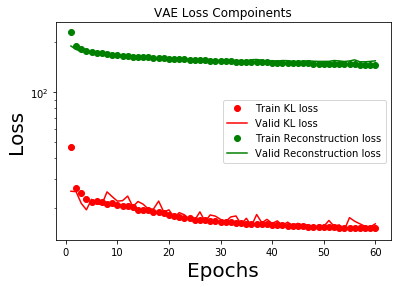

In [14]:
#make a plot for kl and reconstruction loss
kl_train_loss_values1 = hdict1['kl']
kl_valid_loss_values1 = hdict1['val_kl']
recon_train_loss_values1 = hdict1['reconstruction']
recon_valid_loss_values1 = hdict1['val_reconstruction']
epochs1 = range(1, len(train_loss_values1) + 1)
plt.plot(epochs1, kl_train_loss_values1, 'ro', label='Train KL loss')
plt.plot(epochs1, kl_valid_loss_values1, 'r', label='Valid KL loss')
plt.plot(epochs1, recon_train_loss_values1, 'go', label='Train Reconstruction loss')
plt.plot(epochs1, recon_valid_loss_values1, 'g', label='Valid Reconstruction loss')
plt.title('VAE Loss Compoinents')
plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.yscale('log')
plt.legend()
plt.show()
plt.close()

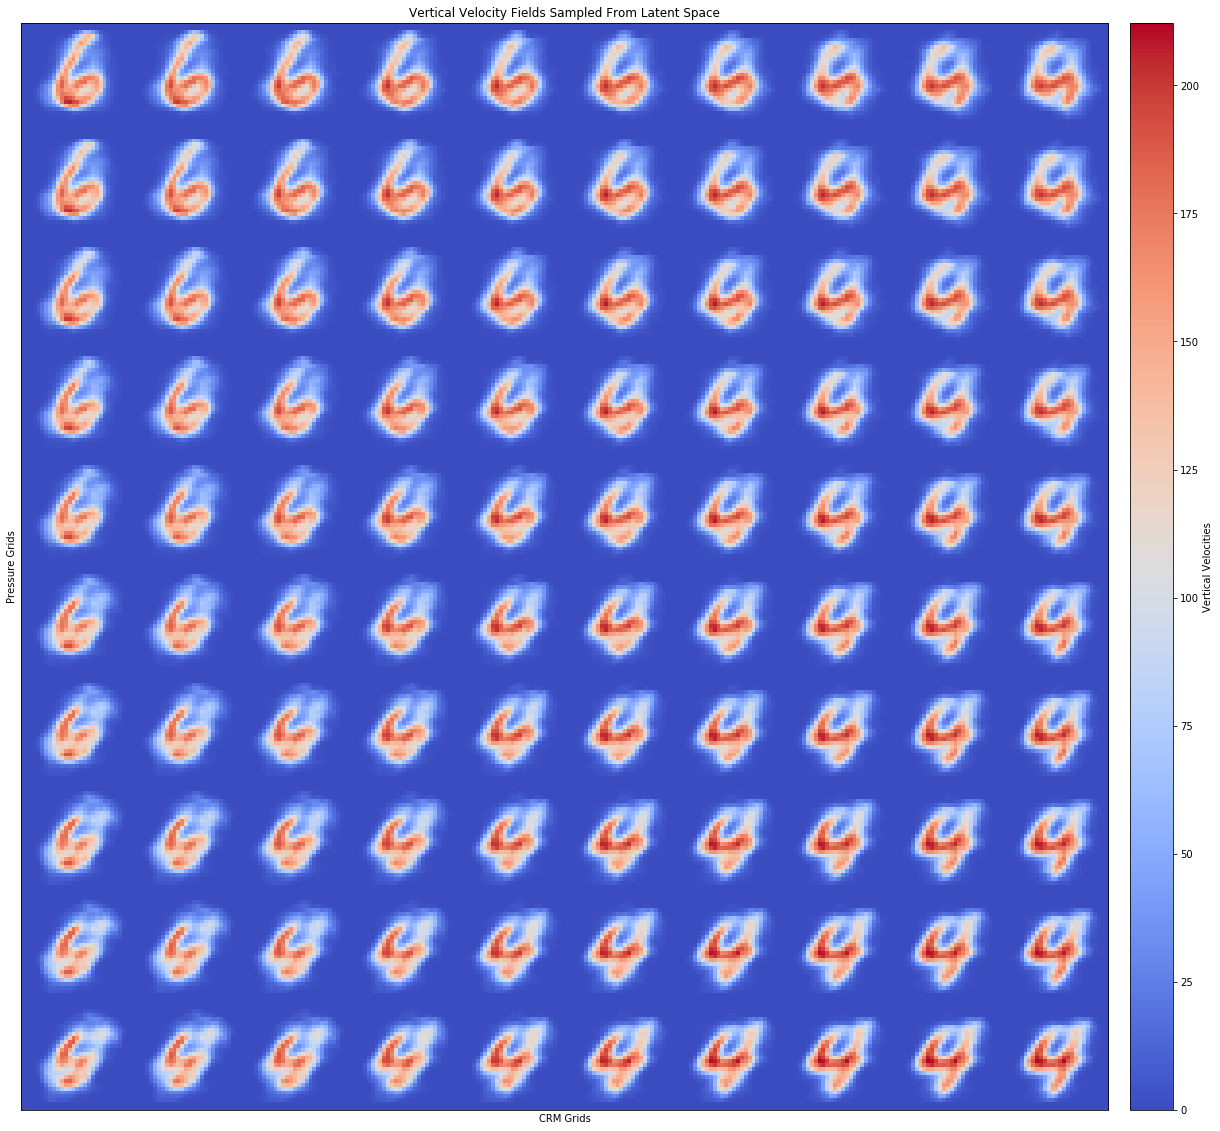

In [16]:
n = 10
digit_size_one = 28
digit_size_two = 28
figure = np.zeros((digit_size_one * n, digit_size_two * n))
grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, codings_size)
        x_decoded = variational_decoder.predict(z_sample, batch_size=batch_size)
        x_decoded = x_decoded*255.
        digit = x_decoded[0].reshape(digit_size_one, digit_size_two)
        figure[i * digit_size_one: (i + 1) * digit_size_one,
            j * digit_size_two: (j + 1) * digit_size_two] = digit

fig = plt.figure(figsize=(30, 20))
ax = plt.axes()
my_plot = plt.imshow(figure, cmap='coolwarm')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(my_plot, label = "Vertical Velocities", cax = cax)
ax.set_ylabel("Pressure Grids")
ax.set_xlabel("CRM Grids")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Vertical Velocity Fields Sampled From Latent Space")
plt.show()

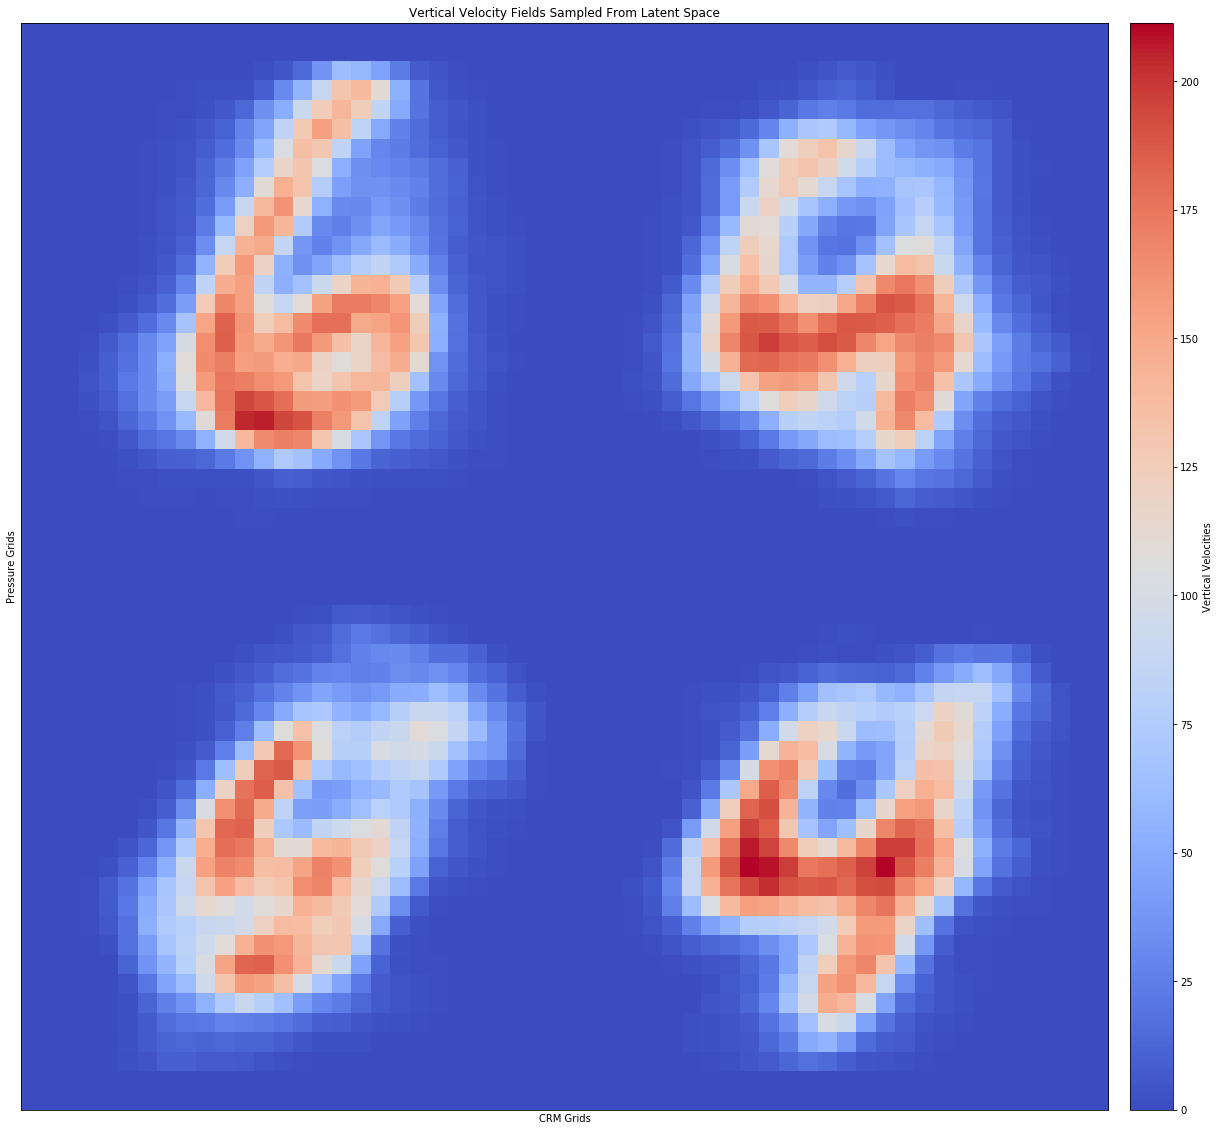

In [17]:
n = 2
digit_size_one = 28
digit_size_two = 28
figure = np.zeros((digit_size_one * n, digit_size_two * n))
grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, codings_size)
        x_decoded = variational_decoder.predict(z_sample, batch_size=batch_size)
        x_decoded = x_decoded*255.
        digit = x_decoded[0].reshape(digit_size_one, digit_size_two)
        figure[i * digit_size_one: (i + 1) * digit_size_one,
            j * digit_size_two: (j + 1) * digit_size_two] = digit

fig = plt.figure(figsize=(30, 20))
ax = plt.axes()
my_plot = plt.imshow(figure, cmap='coolwarm')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(my_plot, label = "Vertical Velocities", cax = cax)
ax.set_ylabel("Pressure Grids")
ax.set_xlabel("CRM Grids")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Vertical Velocity Fields Sampled From Latent Space")
plt.show()

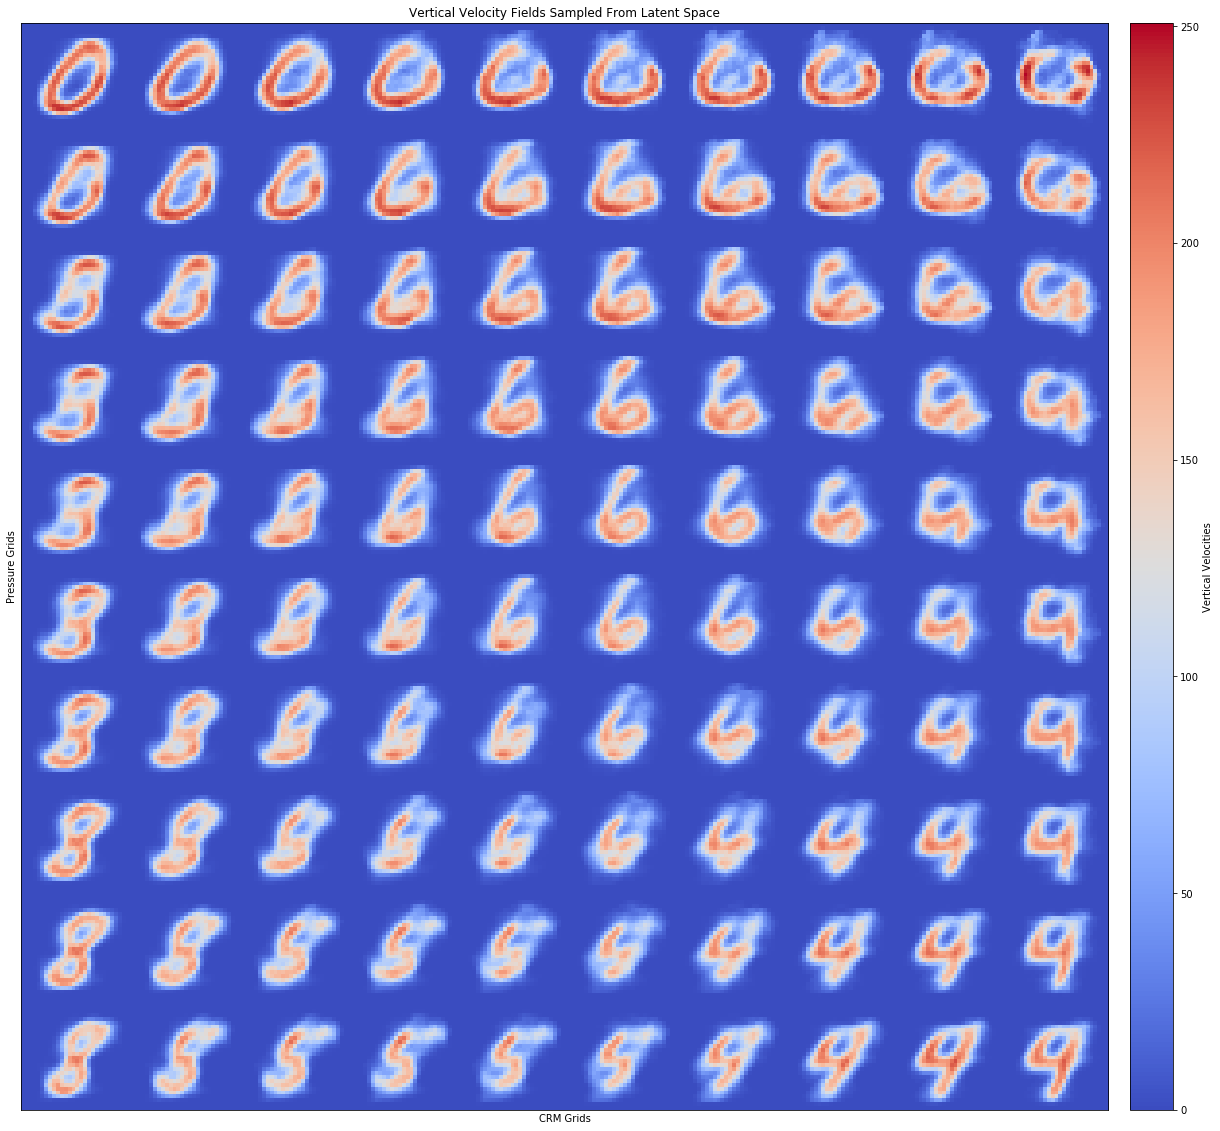

In [21]:
from scipy.stats import norm
n = 10
digit_size_one = 28
digit_size_two = 28
figure = np.zeros((digit_size_one * n, digit_size_two * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, codings_size)
        x_decoded = variational_decoder.predict(z_sample, batch_size=batch_size)
        x_decoded = x_decoded*255.
        digit = x_decoded[0].reshape(digit_size_one, digit_size_two)
        figure[i * digit_size_one: (i + 1) * digit_size_one,
            j * digit_size_two: (j + 1) * digit_size_two] = digit

fig = plt.figure(figsize=(30, 20))
ax = plt.axes()
my_plot = plt.imshow(figure, cmap='coolwarm')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(my_plot, label = "Vertical Velocities", cax = cax)
ax.set_ylabel("Pressure Grids")
ax.set_xlabel("CRM Grids")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Vertical Velocity Fields Sampled From Latent Space")
plt.show()

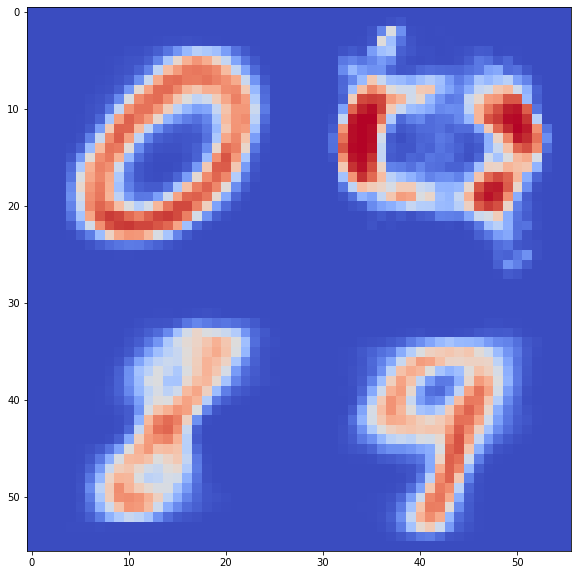

In [22]:
# display a 2D manifold of the digits
n = 2  # figure with 15x15 digits
digit_size_one = 28
digit_size_two = 28
# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.01, 0.99, n))
z_grid = np.dstack(np.meshgrid(z1, z2))

x_pred_grid = variational_decoder.predict(z_grid.reshape(n*n, codings_size)) \
                     .reshape(n, n, digit_size_one, digit_size_two)

x_pred_grid = x_pred_grid*255.
plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='coolwarm')
plt.show()

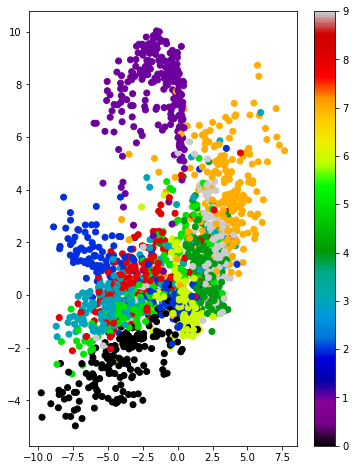

In [23]:
x_test_encoded = np.array(variational_encoder.predict(Test_Images, batch_size = batch_size))
plt.figure(figsize=(6,8))
#plt.scatter(x_test_encoded[:, 0], x_test_encoded[:,1])
plt.scatter(x_test_encoded[2, :,0], x_test_encoded[2, :,1], c=y_test[:2000], cmap='nipy_spectral')
plt.colorbar()
plt.savefig('MNST_Model_Structures/MNST_latent_Space.png')
plt.show()

In [27]:
Predict_Images = variational_ae.predict(Test_Images, batch_size=batch_size)

In [29]:
def min_max_gen(truths, predictions):
    my_list = [truths, predictions]
    max_list = []
    min_list = []
    for i in range(len(my_list)):
        values = my_list[i].ravel()
        max_list.append(np.max(values))
        min_list.append(np.min(values))
        
    vmax = np.max(np.array(max_list))
    vmin = np.min(np.array(min_list))

    return vmin, vmax

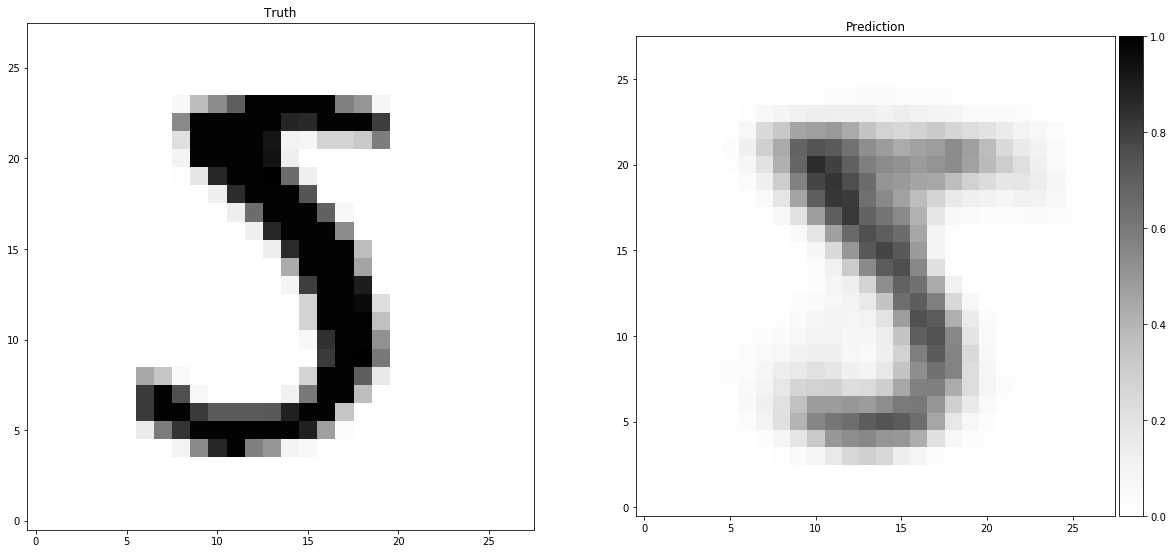

In [32]:
def comparison_gen(truth, pred, location):
    fig, axs = plt.subplots(1, 2, figsize=(20,26))
    cmap = 'Greys'
    image_index = location
    datasets = [truth, pred]
    var_labels = ["Truth", "Prediction"]
    count = 0
    vmin, vmax = min_max_gen(truth[image_index,:,:], pred[image_index,:,:])
    for ax in axs.ravel():
        cs = ax.imshow(np.squeeze(datasets[count][image_index,:,:]), cmap=cmap, vmin = vmin, vmax = vmax)
        if count == 1:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            fig.colorbar(cs, cax=cax)
        ax.set_ylim(ax.get_ylim()[::-1]) 
        ax.set_title(var_labels[count])
        count = count+1
        
comparison_gen(Test_Images, Predict_Images, 1915)